In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

In [2]:
df = sns.load_dataset('titanic')

In [3]:
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [4]:
df.shape

(891, 15)

In [5]:
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())


First few rows:
   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----

In [6]:
df_model = df[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']].copy()

In [7]:
# Encode categorical variables FIRST (before any other operations)
# Sex: male=1, female=0
df_model.loc[:, 'sex'] = df_model['sex'].map({'male': 1, 'female': 0})

# Handle missing values
# Age: fill with median
df_model.loc[:, 'age'] = df_model['age'].fillna(df_model['age'].median())

# Fare: fill with median
df_model.loc[:, 'fare'] = df_model['fare'].fillna(df_model['fare'].median())

# Embarked: fill with mode
df_model.loc[:, 'embarked'] = df_model['embarked'].fillna(df_model['embarked'].mode()[0])

# Feature Engineering
# Create family size feature
df_model.loc[:, 'family_size'] = df_model['sibsp'] + df_model['parch'] + 1

# Create is_alone feature
df_model.loc[:, 'is_alone'] = (df_model['family_size'] == 1).astype(int)

# Embarked: one-hot encoding
df_model = pd.get_dummies(df_model, columns=['embarked'], prefix='embarked', drop_first=True)

In [12]:
print(df_model.head(10))
print(f"\nDataset shape: {df_model.shape}")
print(f"\nColumn names: {list(df_model.columns)}")

   survived  pclass sex   age  sibsp  parch     fare  family_size  is_alone  \
0         0       3   1  22.0      1      0   7.2500            2         0   
1         1       1   0  38.0      1      0  71.2833            2         0   
2         1       3   0  26.0      0      0   7.9250            1         1   
3         1       1   0  35.0      1      0  53.1000            2         0   
4         0       3   1  35.0      0      0   8.0500            1         1   
5         0       3   1  28.0      0      0   8.4583            1         1   
6         0       1   1  54.0      0      0  51.8625            1         1   
7         0       3   1   2.0      3      1  21.0750            5         0   
8         1       3   0  27.0      0      2  11.1333            3         0   
9         1       2   0  14.0      1      0  30.0708            2         0   

   embarked_Q  embarked_S  
0       False        True  
1       False       False  
2       False        True  
3       False     

In [15]:
# Separate features and target
X = df_model.drop('survived', axis=1)
y = df_model['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")



Training set size: 712
Test set size: 179


In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results = {}

In [22]:
print("\n" + "="*50)
print("LOGISTIC REGRESSION")
print("="*50)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_accuracy = accuracy_score(y_test, lr_pred)

print(f"Accuracy: {lr_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, lr_pred))

results['Logistic Regression'] = lr_accuracy


LOGISTIC REGRESSION
Accuracy: 0.8045

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.78      0.68      0.73        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



In [25]:
# Decision Tree
print("\n" + "="*50)
print("DECISION TREE")
print("="*50)

dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_pred)

print(f"Accuracy: {dt_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, dt_pred))

results['Decision Tree'] = dt_accuracy


DECISION TREE
Accuracy: 0.7654

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       110
           1       0.75      0.58      0.66        69

    accuracy                           0.77       179
   macro avg       0.76      0.73      0.74       179
weighted avg       0.76      0.77      0.76       179



In [30]:
# Random Forest
print("\n" + "="*50)
print("RANDOM FOREST")
print("="*50)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

print(f"Accuracy: {rf_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred))



RANDOM FOREST
Accuracy: 0.8101

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.91      0.85       110
           1       0.82      0.65      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.81      0.81       179



In [31]:
# Gradient Boosting
print("\n" + "="*50)
print("GRADIENT BOOSTING")
print("="*50)

gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=3)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print(f"Accuracy: {gb_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, gb_pred))

results['Gradient Boosting'] = gb_accuracy


GRADIENT BOOSTING
Accuracy: 0.8045

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       110
           1       0.80      0.65      0.72        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179



In [32]:
#  MODEL COMPARISON
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
results_df = results_df.sort_values('Accuracy', ascending=False)
print(results_df.to_string(index=False))


MODEL COMPARISON
              Model  Accuracy
Logistic Regression  0.804469
  Gradient Boosting  0.804469
      Decision Tree  0.765363


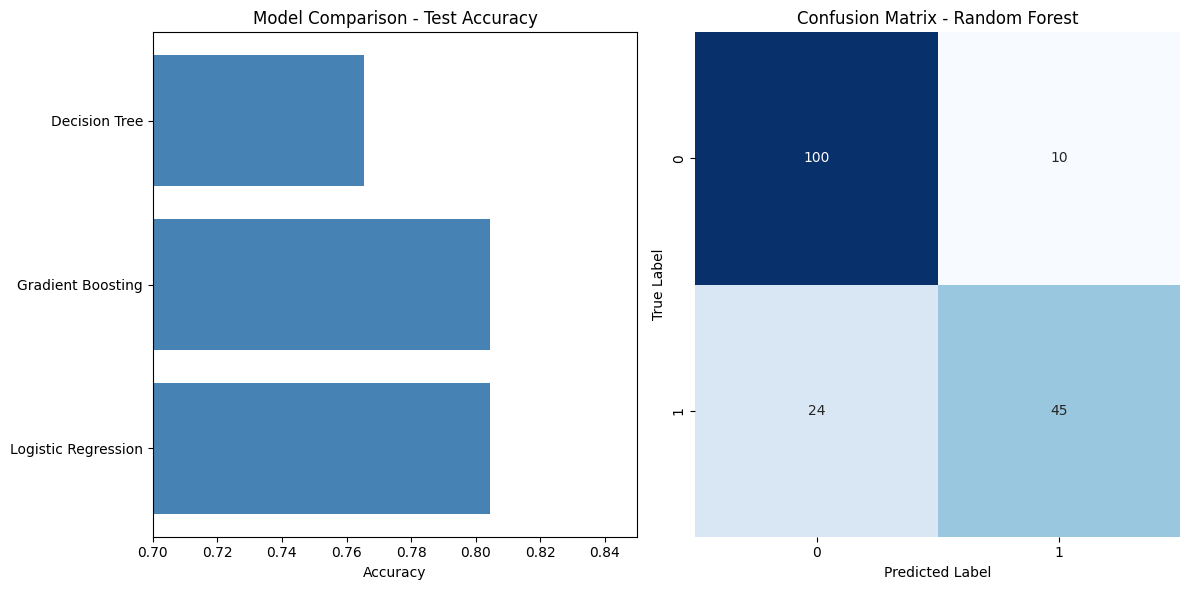

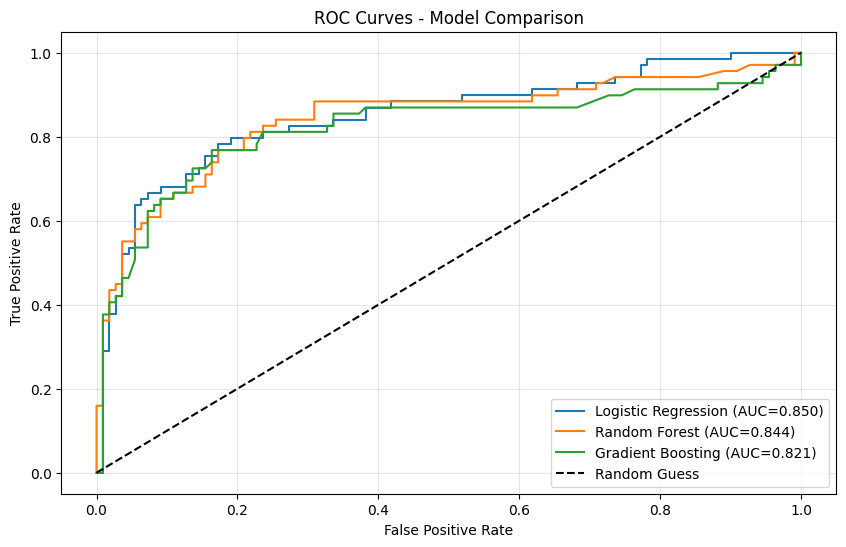


✅ Analysis complete! Models trained and evaluated.
📊 Visualizations saved as PNG files.


In [33]:
# Plot model comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(results_df['Model'], results_df['Accuracy'], color='steelblue')
plt.xlabel('Accuracy')
plt.title('Model Comparison - Test Accuracy')
plt.xlim([0.7, 0.85])

# Confusion Matrix for best model (Random Forest)
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('titanic_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ROC Curve for top models
plt.figure(figsize=(10, 6))

# Get probability predictions
lr_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
rf_proba = rf_model.predict_proba(X_test)[:, 1]
gb_proba = gb_model.predict_proba(X_test)[:, 1]

# Calculate ROC curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_proba)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_proba)
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_proba)

# Plot
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC={roc_auc_score(y_test, lr_proba):.3f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC={roc_auc_score(y_test, rf_proba):.3f})')
plt.plot(gb_fpr, gb_tpr, label=f'Gradient Boosting (AUC={roc_auc_score(y_test, gb_proba):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Analysis complete! Models trained and evaluated.")
print("📊 Visualizations saved as PNG files.")